# Movie Genre Classification

งานนี้รายวิชา DS532 Text Analytics ของ น.ส.ปริยานุช ประเสริฐสิริกุล รหัสนิสิต 63199130345 จะใช้ข้อมูลจากเว็บ IMDB ของหนังที่เป็น Feature Film ในประเทศอเมริกา ตั้งแต่ปี 2018 ถึง 2021 ในการทำนายประเภทหนังจำนวน 10 ประเภท ที่มีมากที่สุด

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
sns.set(style='whitegrid', palette="deep", rc={"figure.figsize": [8, 5]})
%matplotlib inline
warnings.filterwarnings('ignore')

## 1. Web Scrapping

ทำการ Scrape เว็บ IMDB โดยเลือกประเภทหนังเป็น Feature Film ในประเทศอเมริกา ตั้งแต่ปี 2018 ถึง 2021

In [ ]:
from requests import get
from bs4 import BeautifulSoup

page_movie = []

for i in [2018, 2019, 2020, 2021]:
    for j in range(1, 4200, 100):
        url = "https://www.imdb.com/search/title/?title_type=feature&release_date="+str(i)+"-01-01,"+str(i)+"-12-31&countries=us&sort=alpha,asc&count=100&start="+str(j)+"&ref_=adv_nxt"
        response = get(url)
        html_soup = BeautifulSoup(response.text, 'html.parser')
        movie_containers = html_soup.find_all('div', class_ = 'lister-item mode-advanced')

        names = []
        years = []
        genres = []
        descriptions = []

        for container in movie_containers:

            if (container.find('span', attrs = {'class': 'genre'}) is not None) and ((container.find_all('p', attrs={'class':'text-muted'})[-1].text) != '\nAdd a Plot\n'):

                name = container.h3.a.text
                names.append(name)

                year = container.h3.find('span', class_ = 'lister-item-year').text
                years.append(year)

                genre = container.find('span', attrs = {'class': 'genre'}).text
                genres.append(genre)

                description = container.find_all('p', attrs={'class':'text-muted'})[-1].text
                descriptions.append(description)
        test_df = pd.DataFrame({'movie': names,
                                'year': years,
                                'genres': genres,
                                'descriptions': descriptions})
        page_movie.append(test_df)

df = pd.concat(page_movie).reset_index(drop=True)

จะได้ DataFrame หน้าตานี้ที่ Scrape มานั้น ซึ่งมี 4 คอลัมน์ ได้แก่ movie year genres descriptions

In [ ]:
# df.to_excel('df.xlsx', index=False)
df = pd.read_excel('/content/drive/MyDrive/MSDS/Text Analytic/Movie Genre Classification/df.xlsx')
df.head()

,movie,year,genres,descriptions
0,#1915House,(2018),"\nHorror, Thriller",\nA century of secrets are hidden behind the f...
1,#SquadGoals,(2018),"\nDrama, Thriller","\nSamantha is a serious journalist, both for t..."
2,#Victoria,(2018),"\nAction, Drama",\nVictoria moves from out of town into the poo...
3,1 Angry Black Man,(2018),\nDrama,\nMike Anderson is a senior at the quintessent...
4,"1 Dead man, 6 Suspects, $65 Million",(2018),\nMystery,"\nA low budget but slick ""who done it"" involvi..."


## 2. Data Preparation

เริ่มจากการตรวจสอบปีที่ผลิตหนัง พบว่ามีตัวเลขโรมันเข้ามาด้วย

In [ ]:
df.year.unique()

array(['(2018)', '(I) (2018)', nan, '(II) (2018)', '(III) (2018)',
       '(IV) (2018)', '(V) (2018)', '(IX) (2018)', '(XXIII)',
       '(VI) (2018)', '(VIII) (2018)', '(2019)', '(VII)',
       '(XVIII) (2018)', '(I)', '(II)', '(XVI) (2018)', '(II) (2019)',
       '(I) (2019)', '(IV) (2019)', '(V) (2019)', '(III) (2019)',
       '(VI) (2019)', '(VIII) (2019)', '(XXXV) (2019)', '(VII) (2019)',
       '(X) (2019)', '(IX) (2019)', '(XII) (2019)', '(2020)',
       '(III) (2020)', '(II) (2020)', '(I) (2020)', '(XXI) (2020)',
       '(V) (2020)', '(VI) (2020)', '(IV) (2020)', '(2021)',
       '(VIII) (2020)', '(XI) (2020)', '(I) (2021)', '(II) (2021)',
       '(IV) (2021)', '(XII) (2021)', '(III) (2021)', '(VI) (2021)',
       '(V) (2021)', '(VI)'], dtype=object)

ดังนั้น ทำความสะอาดข้อมูลด้วยการดึงเฉพาะตัวเลข ซึ่งเป็นปีที่ผลิตหนัง และส่งผลต่อค่าที่เป็นตัวเลขโรมัน โดยที่ไม่มีการผสมปี จะได้ null จึงเติมปีแทนจากการข้อมูลก่อนหน้านี้

In [ ]:
df.year = df.year.str.extract('(\d+)')
df.year = df.year.ffill(axis = 0)
df.year.unique()

array(['2018', '2019', '2020', '2021'], dtype=object)

ต่อไปทำความสะอาดประเภทหนังด้วยการลบคำว่า '\n'

In [ ]:
df.genres = df.genres.str.strip()
df.head()

,movie,year,genres,descriptions
0,#1915House,2018,"Horror, Thriller",\nA century of secrets are hidden behind the f...
1,#SquadGoals,2018,"Drama, Thriller","\nSamantha is a serious journalist, both for t..."
2,#Victoria,2018,"Action, Drama",\nVictoria moves from out of town into the poo...
3,1 Angry Black Man,2018,Drama,\nMike Anderson is a senior at the quintessent...
4,"1 Dead man, 6 Suspects, $65 Million",2018,Mystery,"\nA low budget but slick ""who done it"" involvi..."


ประเภทหนังนั้นใน 1 เรื่อง มีอย่างน้อย 1 ประเภท จึงต้องสร้างตัวแปร genres สำหรับการทำ One-hot Encoding โดยสร้างคอลัมน์แต่ละประเภท

In [ ]:
genres = df.genres.tolist()
genres = ", ".join(genres)
genres = sorted(list(set(genres.split(", "))))
genres

['Action',
 'Adventure',
 'Animation',
 'Biography',
 'Comedy',
 'Crime',
 'Drama',
 'Family',
 'Fantasy',
 'Game-Show',
 'History',
 'Horror',
 'Music',
 'Musical',
 'Mystery',
 'News',
 'Reality-TV',
 'Romance',
 'Sci-Fi',
 'Sport',
 'Talk-Show',
 'Thriller',
 'War',
 'Western']

พบว่า Datafame มีหน้าตานี้

In [ ]:
for g in genres:
  df[g] = df["genres"].apply(lambda x: 1 if len(set(x.split(", ")).intersection(set([g]))) > 0 else 0)
df.head()

,movie,year,genres,descriptions,Action,Adventure,Animation,Biography,Comedy,Crime,Drama,Family,Fantasy,Game-Show,History,Horror,Music,Musical,Mystery,News,Reality-TV,Romance,Sci-Fi,Sport,Talk-Show,Thriller,War,Western
0,#1915House,2018,"Horror, Thriller",\nA century of secrets are hidden behind the f...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
1,#SquadGoals,2018,"Drama, Thriller","\nSamantha is a serious journalist, both for t...",0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,#Victoria,2018,"Action, Drama",\nVictoria moves from out of town into the poo...,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1 Angry Black Man,2018,Drama,\nMike Anderson is a senior at the quintessent...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,"1 Dead man, 6 Suspects, $65 Million",2018,Mystery,"\nA low budget but slick ""who done it"" involvi...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


ตรวจสอบใน Dataframe นี้ ว่ามีค่า null ในคอลัมน์ใดคอลัมน์หนึ่งหรือไม่ พบว่าไม่มีค่า null ใดๆ

In [ ]:
df.isnull().any()

movie           False
year            False
genres          False
descriptions    False
Action          False
Adventure       False
Animation       False
Biography       False
Comedy          False
Crime           False
Drama           False
Family          False
Fantasy         False
Game-Show       False
History         False
Horror          False
Music           False
Musical         False
Mystery         False
News            False
Reality-TV      False
Romance         False
Sci-Fi          False
Sport           False
Talk-Show       False
Thriller        False
War             False
Western         False
dtype: bool

แสดงจำนวนเรื่องในแต่ละประเภทหนัง โดยเรียงจำนวนมากไปน้อย จะเห็นว่า มีการผลิตหนังประเภท Drama มากที่สุด และผลิตหนังประเภท Game-Show น้อยที่สุด

In [ ]:
df.loc[:, genres].sum().sort_values(ascending=False)

Drama         5177
Comedy        3046
Horror        2339
Thriller      2171
Action        1420
Crime          937
Romance        834
Adventure      777
Mystery        714
Sci-Fi         698
Family         569
Animation      503
Fantasy        490
Biography      240
Music          215
Musical        170
Western        150
History        148
Sport          110
War             84
Reality-TV      19
Talk-Show       16
News             7
Game-Show        1
dtype: int64

งานนี้ใช้ทำนายประเภทหนัง 10 ประเภทที่มีมากที่สุด

In [ ]:
df = df[['movie', 'year', 'genres', 'descriptions', 'Drama', 'Comedy', 'Horror', 'Thriller', 'Action', 'Crime', 'Romance', 'Adventure', 'Mystery', 'Sci-Fi']]
df.shape

(12388, 14)

drop เรื่องที่ไม่ได้อยู่ใน 10 ประเภทนั้น

In [ ]:
index_names = df[(df['Drama']==0)&(df['Comedy']==0)&(df['Horror']==0)&(df['Thriller']==0)&(df['Action']==0)&(df['Crime']==0)&(df['Romance']==0)&(df['Adventure']==0)&(df['Mystery']==0)&(df['Sci-Fi']==0)].index
df = df.drop(index_names)
df.tail(10)

,movie,year,genres,descriptions,Drama,Comedy,Horror,Thriller,Action,Crime,Romance,Adventure,Mystery,Sci-Fi
12377,Zed's Dead,2021,Adventure,\nTake a plunge into the morbid world of Z and...,0,0,0,0,0,0,0,1,0,0
12378,Zero Avenue,2021,"Horror, Romance","\nJoshua, a reluctant immortal, plans to end h...",0,0,1,0,0,0,1,0,0,0
12379,Zero Contact,2021,Thriller,\nProduced in 17 different countries entirely ...,0,0,0,1,0,0,0,0,0,0
12380,Zeros and Ones,2021,"Thriller, War",\nAn American soldier stationed in Rome with t...,0,0,0,1,0,0,0,0,0,0
12381,Zidane Adams: The Black Blogger!,2021,Drama,"\nThe life of a cynical, black blogger, former...",1,0,0,0,0,0,0,0,0,0
12383,Zone Drifter,2021,Sci-Fi,"\nIn the distant future, a former soldier batt...",0,0,0,0,0,0,0,0,0,1
12384,Zooey,2021,"Comedy, Drama, Sci-Fi","\nWhen a young boy, Noah, meets Zooey, a young...",1,1,0,0,0,0,0,0,0,1
12385,Zwtral,2021,Mystery,\nMaking trades is his life. Justin finds hims...,0,0,0,0,0,0,0,0,1,0
12386,d'ILLUSION: The Houdini Musical,2021,"Biography, Drama, Musical",\nThe University of Cincinnati - College-Conse...,1,0,0,0,0,0,0,0,0,0
12387,iGilbert,2021,Drama,"\nGilbert Gonzalez (Adrian Martinez), feels is...",1,0,0,0,0,0,0,0,0,0


ต่อไปแสดง descriptions ของหนัง ให้เห็นภาพรวม เพื่อปรับคำให้เหมาะสมกับการทำนายประเภทหนังผิดน้อยที่สุด

In [ ]:
df.descriptions.tolist()[:20]

["\nA century of secrets are hidden behind the fresh paint and modern additions. Peeling back the layers is letting something escape, and he might not see it till it's too late.",
 "\nSamantha is a serious journalist, both for the school paper and for the yearbook, but she's just as serious about her friends, Nate, Gillian, and Rudy, all of whom are vying with her for a full-ride local scholarship to college.",
 '\nVictoria moves from out of town into the poor inner city of New York with her father, the neighborhood drug dealer. She goes on a journey, seeking answers, justice, and revenge after her ...                See full summary\xa0»\n',
 '\nMike Anderson is a senior at the quintessential New-England liberal arts school, Frost College. And Mike is eight weeks away from graduation. On this particular day he has his ...                See full summary\xa0»\n',
 '\nA low budget but slick "who done it" involving the murder of a wealthy businessman. The long list of suspects includes t

เปลี่ยนคำย่อภาษาอังกฤษให้เป็นชื่อเต็ม ลบสัญลักษณ์ที่ไม่ใช่ตัวอักษรหรือตัวเลข และลบประโยคที่ไม่มีความหมายอย่างเช่น See full summary\xa0»

In [ ]:
import re
df['corpus'] = df['descriptions'].str.strip()
df['corpus'] = df['corpus'].str.replace('...                See full summary\xa0»', '', regex=True)
df['corpus'] = df['corpus'].str.lower()
df['corpus'] = df['corpus'].map(lambda x: re.sub("what's", 'what is', x))
df['corpus'] = df['corpus'].map(lambda x: re.sub("'s", '', x))
df['corpus'] = df['corpus'].map(lambda x: re.sub("'ve", ' have', x))
df['corpus'] = df['corpus'].map(lambda x: re.sub("'re", ' are', x))
df['corpus'] = df['corpus'].map(lambda x: re.sub("can't", 'can not', x))
df['corpus'] = df['corpus'].map(lambda x: re.sub("n't", ' not', x))
df['corpus'] = df['corpus'].map(lambda x: re.sub("'ll", ' will', x))
df['corpus'] = df['corpus'].map(lambda x: re.sub("[,\/.!?():;$%&*@#^+=~_{}<>`]", '', x))
df['corpus'] = df['corpus'].str.replace('"', '', regex=True)

import nltk ไปทำการตัดประโยค ตัดคำ ลบคำทั่วๆไปที่ไม่ค่อยช่วยในการสื่อความหมาย แปลงคำให้อยู่ในรูปฟอร์มพื้นฐาน

In [ ]:
import nltk
from nltk.stem.porter import *
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import *
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
def stopword_removal(x, stpws=stopwords.words("english")):
  return list(set(x).difference(set(stpws)))

def lemmatization(x, stemmer=PorterStemmer()):
  return [stemmer.stem(i) for i in x]

def number_removal(x):
  return [i for i in x if not i.isnumeric()]

df['corpus'] = df['corpus'].apply(lambda x: word_tokenize(x))
df['corpus'] = df['corpus'].apply(lambda x: stopword_removal(x))
df['corpus'] = df['corpus'].apply(lambda x: lemmatization(x))
df['corpus'] = df['corpus'].apply(lambda x: number_removal(x))
df['corpus'] = df['corpus'].apply(lambda x: " ".join(x))
df['corpus'].tolist()[0:20]

['centuri addit back secret behind see layer someth paint peel might late hidden escap modern fresh let till',
 'school full-rid seriou nate samantha paper scholarship local colleg vy journalist gillian friend yearbook rudi',
 'goe new justic victoria move seek reveng citi inner town answer york journey drug father neighborhood dealer poor',
 'school new-england away eight quintessenti particular liber mike day graduat anderson colleg week senior art frost',
 'greedi includ businessman long low budget wealthi murder assort shadi involv done famili butler slick suspect attorney list',
 'revis pregnant old mayb year lissa life',
 'go group face struggl togeth detox island friend realiz problem',
 'shift live mysteri artist intellig other man version parallel scientist spi whim three',
 'member morri valdez compromis younger partnerlov parti feder black detect undercov status111 nypd jame hunt brother panther ralphi',
 'new forc tell leadership afghan must special strong first stori talib

เรียกใช้ Dataframe ที่มีการอัพเดทอีกครั้ง เพื่อเตรียมความพร้อมการเข้าสู่ Model

In [ ]:
df.head()

,movie,year,genres,descriptions,Drama,Comedy,Horror,Thriller,Action,Crime,Romance,Adventure,Mystery,Sci-Fi,corpus
0,#1915House,2018,"Horror, Thriller",\nA century of secrets are hidden behind the f...,0,0,1,1,0,0,0,0,0,0,centuri addit back secret behind see layer som...
1,#SquadGoals,2018,"Drama, Thriller","\nSamantha is a serious journalist, both for t...",1,0,0,1,0,0,0,0,0,0,school full-rid seriou nate samantha paper sch...
2,#Victoria,2018,"Action, Drama",\nVictoria moves from out of town into the poo...,1,0,0,0,1,0,0,0,0,0,goe new justic victoria move seek reveng citi ...
3,1 Angry Black Man,2018,Drama,\nMike Anderson is a senior at the quintessent...,1,0,0,0,0,0,0,0,0,0,school new-england away eight quintessenti par...
4,"1 Dead man, 6 Suspects, $65 Million",2018,Mystery,"\nA low budget but slick ""who done it"" involvi...",0,0,0,0,0,0,0,0,1,0,greedi includ businessman long low budget weal...


Export Dataframe เป็นไฟล์ excel เพื่อความรวดเร็วการเรียกใช้งานต่อเนื่อง โดยไม่ต้องทำความสะอาดข้อมูลอีกครั้ง

In [3]:
# df.to_excel('df_clean.xlsx', index=False)
df = pd.read_excel('/content/drive/MyDrive/MSDS/Text Analytic/Movie Genre Classification/df_clean.xlsx')

## Count Vectorization

สร้าง vector space model ในการทำ Count Vetorizer เพื่อ EDA ว่า word ใน description ของหนังเป็นอย่างไร พบว่ายังมี word ที่เป็นตัวเลข, Ordinal Number, ปี

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
corpus = df['corpus'].tolist()
vectorizer_count = CountVectorizer(stop_words='english')
vectorizer_count.fit_transform(corpus)
print(vectorizer_count.get_feature_names()[:200])

['09', '10', '100', '10000th', '100am', '10th', '11', '1100', '11th', '12', '12th', '13', '13th', '14', '141', '14th', '15', '1500', '15th', '16', '16mm', '16th', '17', '17th', '18', '18th', '19', '1913', '1930samerica', '1931', '1948he', '1960sand', '1967five', '1969they', '1990s', '19th', '1m', '1st', '20', '200', '2000', '2008', '200th', '2015', '2017', '20th', '21', '218', '21st', '22', '22nd', '23', '24', '24th', '24year', '25th', '25yr', '26', '27', '27th', '28', '29', '2d', '2film', '2nd', '2rd', '30', '30th', '31st', '33', '347', '35', '35mm', '35th', '36', '38', '39', '3d', '3rd', '3w', '3x', '40', '4077th', '40th', '4225envis', '45th', '47', '4k', '4th', '50', '500', '50k', '50m', '5am', '5g', '5th', '60', '60k', '65', '67', '6am', '6th', '70', '75', '7th', '80', '80s', '84', '8am', '8beat', '8th', '90', '901', '92', '93', '95', '99', '9mm', 'aa', 'aach', 'aaron', 'aau', 'ab', 'abaddon', 'abalon', 'abandon', 'abandonato', 'abano', 'abbess', 'abbey', 'abbi', 'abbott', 'abduct'

ดังนั้น ลบ word ที่มีตัวเลข แล้วจากนั้นทำ Count Vetorizer อีกครั้ง พบว่าไม่มี feature ที่เป็นตัวเลข, Ordinal Number, ปี แล้ว

In [5]:
import re
df['corpus'] = df['corpus'].map(lambda x: re.sub("[0123456789]", '', x))
corpus = df['corpus'].tolist()
vectorizer_count.fit_transform(corpus)
print(vectorizer_count.get_feature_names()[:200])
print('Number of words in corpus is ', len(vectorizer_count.get_feature_names()))

['aa', 'aach', 'aaron', 'aau', 'ab', 'abaddon', 'abalon', 'abandon', 'abandonato', 'abano', 'abbess', 'abbey', 'abbi', 'abbott', 'abduct', 'abducte', 'abductor', 'abdul', 'abe', 'abel', 'abid', 'abigail', 'abigor', 'abil', 'abilen', 'abject', 'abl', 'able', 'abnorm', 'aboard', 'abod', 'abolit', 'abolitionist', 'abomin', 'abort', 'abound', 'aboutsketch', 'abraham', 'abram', 'abroad', 'abrupt', 'abruptli', 'abs', 'abscond', 'absenc', 'absent', 'absente', 'absolut', 'absorb', 'abstin', 'abstract', 'absurd', 'absurdist', 'abu', 'abund', 'abus', 'abuzz', 'abysm', 'abyss', 'academ', 'academi', 'acassuso', 'accept', 'access', 'accid', 'accident', 'acclaim', 'acclimat', 'accolad', 'accommod', 'accompani', 'accompanist', 'accomplic', 'accomplish', 'accord', 'accost', 'account', 'accumul', 'accur', 'accus', 'ace', 'achiev', 'acid', 'ackerman', 'acknowledg', 'acpd', 'acquaint', 'acquir', 'acquit', 'acr', 'act', 'action', 'actioncomedi', 'actiondrama', 'actionthril', 'activ', 'activist', 'actor', 

จากการทำ Count Vectorizer กับ word ใน corpus รวมทุกเรื่องทุกประเภทหนัง พบว่าคำว่า life มีความถี่มากที่สุด

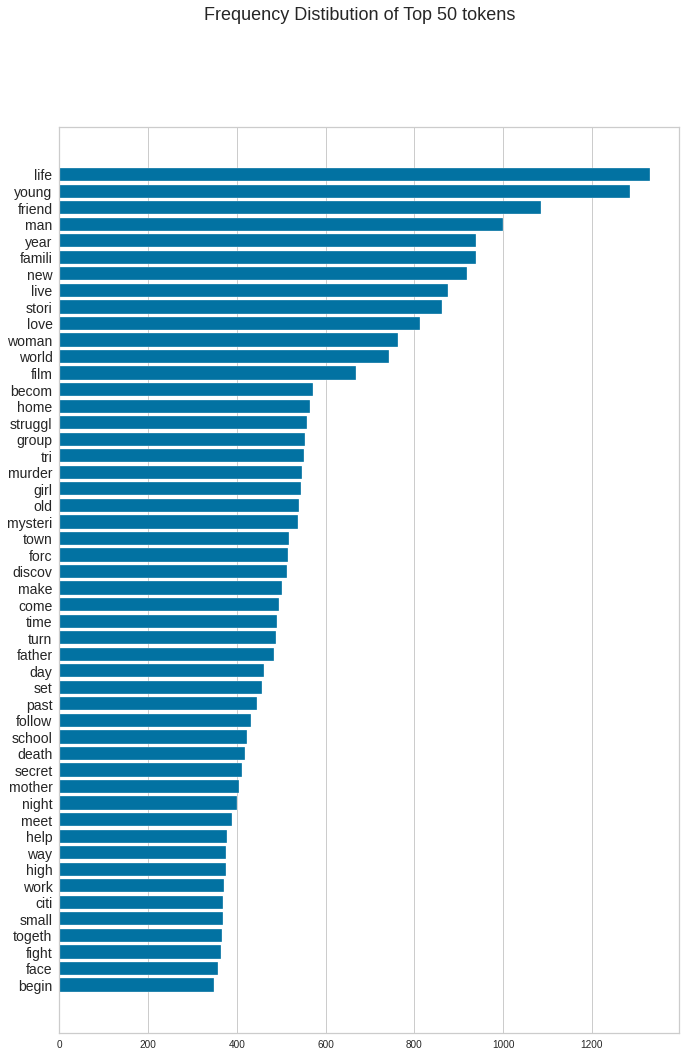

In [ ]:
from yellowbrick.text import FreqDistVisualizer
docs = vectorizer_count.fit_transform(corpus)
features = vectorizer_count.get_feature_names()

visualizer = FreqDistVisualizer(features=features, n=50, size=(800, 1200))
visualizer.fit(docs)

plt.suptitle("Frequency Distibution of Top 50 tokens", size=18)
plt.yticks(fontsize=14);

ต่อมาทำ WordCloud แต่ละประเภทหนัง ให้เห็นภาพรวมของคำที่มีความถี่มากที่สุดจำนวน 30 คำ
1. ตอนทำ Word Cloud ประเภท Drama ครั้งแรก พบว่ามีคำที่ไม่น่าสื่อความหมายในการทำนายประเภทหนัง ได้แก่ 'one', 'two', 'take', 'tri', 'must', 'new', 'becom', 'follow', 'make', 'world', 'come', 'set', 'film', 'turn' จึงสร้างตัวแปรสำหรับการเพิ่มคำเหล่านี้ในที่เก็บ stopword และทำ Word Cloud ใหม่ ดังภาพ

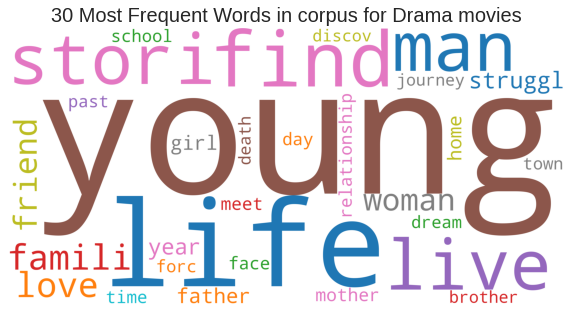

In [ ]:
import itertools
from wordcloud import WordCloud, STOPWORDS
df_wordcloud = df.loc[df['Drama']==1, ['corpus']]
list_wordcloud = [x for x in df_wordcloud['corpus'].str.split()]
list_wordcloud = list(itertools.chain(*list_wordcloud))

stopwords = set(STOPWORDS)
add_stopwords = {'one', 'two', 'take', 'tri', 'must', 'new', 'becom', 'follow', 'make', 'world', 'come', 'set', 'film', 'turn'}
stopwords = stopwords.union(add_stopwords)

plot_wordcloud = ' '.join(list_wordcloud)
plot_wordcloud = WordCloud(stopwords=stopwords, background_color='white', max_words = 30, height=2000, width=4000, random_state = 42, 
                           normalize_plurals = False, colormap='tab10').generate(plot_wordcloud)

fig, ax = plt.subplots(figsize=(10,6))
plt.imshow(plot_wordcloud)
plt.title('30 Most Frequent Words in corpus for Drama movies', fontsize = 20)
plt.axis("off")
plt.show();

2. ตอนทำ Word Cloud ประเภท Comedy ครั้งแรก พบว่ามีคำที่ไม่น่าสื่อความหมายในการทำนายประเภทหนัง ได้แก่ 'back', 'best', 'go', 'togeth', 'three' จึงสร้างตัวแปรสำหรับการเพิ่มคำเหล่านี้ในที่เก็บ stopword ต่อไป และทำ Word Cloud ใหม่ ดังภาพ

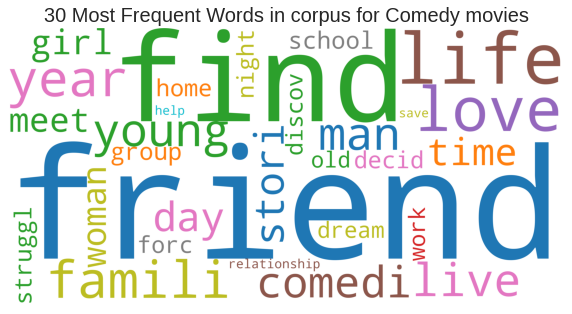

In [ ]:
df_wordcloud = df.loc[df['Comedy']==1, ['corpus']]
list_wordcloud = [x for x in df_wordcloud['corpus'].str.split()]
list_wordcloud = list(itertools.chain(*list_wordcloud))

add2_stopwords = {'back', 'best', 'go', 'togeth', 'three'}
stopwords = stopwords.union(add2_stopwords)

plot_wordcloud = ' '.join(list_wordcloud)
plot_wordcloud = WordCloud(stopwords=stopwords, background_color='white', max_words = 30, height=2000, width=4000, random_state = 42, 
                           normalize_plurals = False, colormap='tab10').generate(plot_wordcloud)

fig, ax = plt.subplots(figsize=(10,6))
plt.imshow(plot_wordcloud)
plt.title('30 Most Frequent Words in corpus for Comedy movies', fontsize = 20)
plt.axis("off")
plt.show();

3. ตอนทำ Word Cloud ประเภท Horror ครั้งแรก พบว่ามีคำที่ไม่น่าสื่อความหมายในการทำนายประเภทหนัง คือ 'begin' จึงสร้างตัวแปรสำหรับการเพิ่มคำเหล่านี้ในที่เก็บ stopword ต่อไป และทำ Word Cloud ใหม่ ดังภาพ

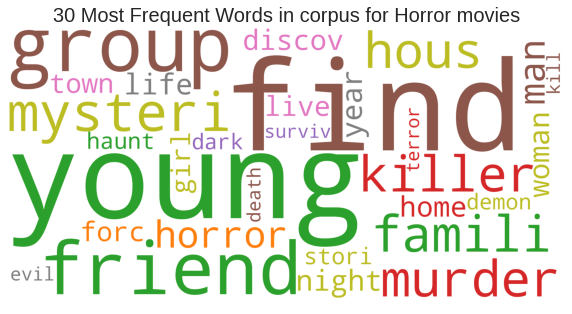

In [ ]:
df_wordcloud = df.loc[df['Horror']==1, ['corpus']]
list_wordcloud = [x for x in df_wordcloud['corpus'].str.split()]
list_wordcloud = list(itertools.chain(*list_wordcloud))

add3_stopwords = {'begin'}
stopwords = stopwords.union(add3_stopwords)

plot_wordcloud = ' '.join(list_wordcloud)
plot_wordcloud = WordCloud(stopwords=stopwords, background_color='white', max_words = 30, height=2000, width=4000, random_state = 42, 
                           normalize_plurals = False, colormap='tab10').generate(plot_wordcloud)

fig, ax = plt.subplots(figsize=(10,6))
plt.imshow(plot_wordcloud)
plt.title('30 Most Frequent Words in corpus for Horror movies', fontsize = 20)
plt.axis("off")
plt.show();

4. แสดง Word Cloud ประเภท Thriller ไม่พบว่ามีคำที่ไม่น่าสื่อความหมายในการทำนายประเภทหนัง ดังภาพ

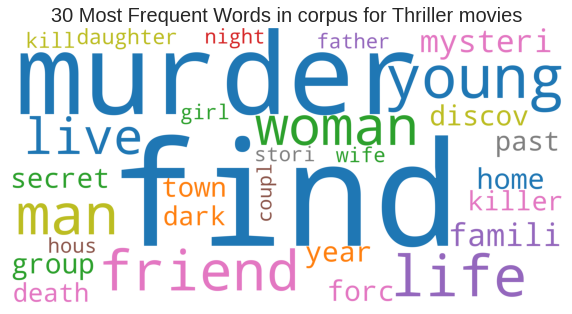

In [ ]:
df_wordcloud = df.loc[df['Thriller']==1, ['corpus']]
list_wordcloud = [x for x in df_wordcloud['corpus'].str.split()]
list_wordcloud = list(itertools.chain(*list_wordcloud))

plot_wordcloud = ' '.join(list_wordcloud)
plot_wordcloud = WordCloud(stopwords=stopwords, background_color='white', max_words = 30, height=2000, width=4000, random_state = 42, 
                           normalize_plurals = False, colormap='tab10').generate(plot_wordcloud)

fig, ax = plt.subplots(figsize=(10,6))
plt.imshow(plot_wordcloud)
plt.title('30 Most Frequent Words in corpus for Thriller movies', fontsize = 20)
plt.axis("off")
plt.show();

5. แสดง Word Cloud ประเภท Action ไม่พบว่ามีคำที่ไม่น่าสื่อความหมายในการทำนายประเภทหนัง ดังภาพ

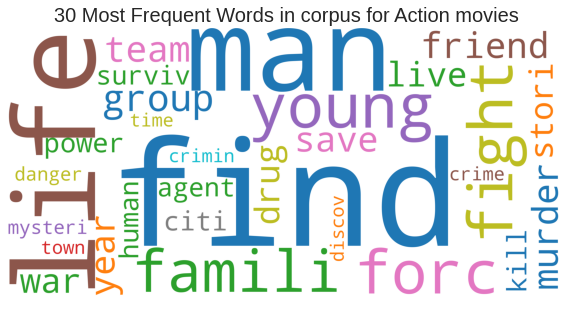

In [ ]:
df_wordcloud = df.loc[df['Action']==1, ['corpus']]
list_wordcloud = [x for x in df_wordcloud['corpus'].str.split()]
list_wordcloud = list(itertools.chain(*list_wordcloud))

plot_wordcloud = ' '.join(list_wordcloud)
plot_wordcloud = WordCloud(stopwords=stopwords, background_color='white', max_words = 30, height=2000, width=4000, random_state = 42, 
                           normalize_plurals = False, colormap='tab10').generate(plot_wordcloud)

fig, ax = plt.subplots(figsize=(10,6))
plt.imshow(plot_wordcloud)
plt.title('30 Most Frequent Words in corpus for Action movies', fontsize = 20)
plt.axis("off")
plt.show();

6. แสดง Word Cloud ประเภท Crime ไม่พบว่ามีคำที่ไม่น่าสื่อความหมายในการทำนายประเภทหนัง ดังภาพ

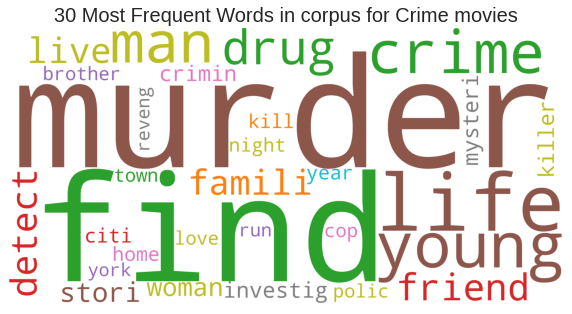

In [ ]:
df_wordcloud = df.loc[df['Crime']==1, ['corpus']]
list_wordcloud = [x for x in df_wordcloud['corpus'].str.split()]
list_wordcloud = list(itertools.chain(*list_wordcloud))

plot_wordcloud = ' '.join(list_wordcloud)
plot_wordcloud = WordCloud(stopwords=stopwords, background_color='white', max_words = 30, height=2000, width=4000, random_state = 42, 
                           normalize_plurals = False, colormap='tab10').generate(plot_wordcloud)

fig, ax = plt.subplots(figsize=(10,6))
plt.imshow(plot_wordcloud)
plt.title('30 Most Frequent Words in corpus for Crime movies', fontsize = 20)
plt.axis("off")
plt.show();

7. แสดง Word Cloud ประเภท Romance ไม่พบว่ามีคำที่ไม่น่าสื่อความหมายในการทำนายประเภทหนัง ดังภาพ

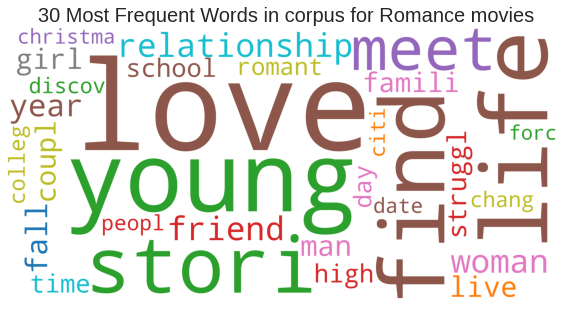

In [ ]:
df_wordcloud = df.loc[df['Romance']==1, ['corpus']]
list_wordcloud = [x for x in df_wordcloud['corpus'].str.split()]
list_wordcloud = list(itertools.chain(*list_wordcloud))

add4_stopwords = {'way'}
stopwords = stopwords.union(add4_stopwords)

plot_wordcloud = ' '.join(list_wordcloud)
plot_wordcloud = WordCloud(stopwords=stopwords, background_color='white', max_words = 30, height=2000, width=4000, random_state = 42, 
                           normalize_plurals = False, colormap='tab10').generate(plot_wordcloud)

fig, ax = plt.subplots(figsize=(10,6))
plt.imshow(plot_wordcloud)
plt.title('30 Most Frequent Words in corpus for Romance movies', fontsize = 20)
plt.axis("off")
plt.show();

8. ตอนทำ Word Cloud ประเภท Adventure ครั้งแรก พบว่ามีคำที่ไม่น่าสื่อความหมายในการทำนายประเภทหนัง คือ 'way' จึงสร้างตัวแปรสำหรับการเพิ่มคำเหล่านี้ในที่เก็บ stopword ต่อไป และทำ Word Cloud ใหม่ ดังภาพ

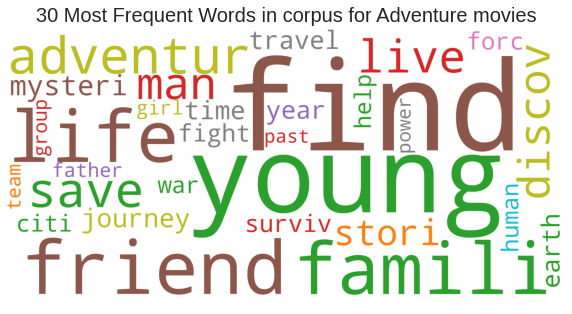

In [ ]:
df_wordcloud = df.loc[df['Adventure']==1, ['corpus']]
list_wordcloud = [x for x in df_wordcloud['corpus'].str.split()]
list_wordcloud = list(itertools.chain(*list_wordcloud))

plot_wordcloud = ' '.join(list_wordcloud)
plot_wordcloud = WordCloud(stopwords=stopwords, background_color='white', max_words = 30, height=2000, width=4000, random_state = 42, 
                           normalize_plurals = False, colormap='tab10').generate(plot_wordcloud)

fig, ax = plt.subplots(figsize=(10,6))
plt.imshow(plot_wordcloud)
plt.title('30 Most Frequent Words in corpus for Adventure movies', fontsize = 20)
plt.axis("off")
plt.show();

9. แสดง Word Cloud ประเภท Mystery ไม่พบว่ามีคำที่ไม่น่าสื่อความหมายในการทำนายประเภทหนัง ดังภาพ

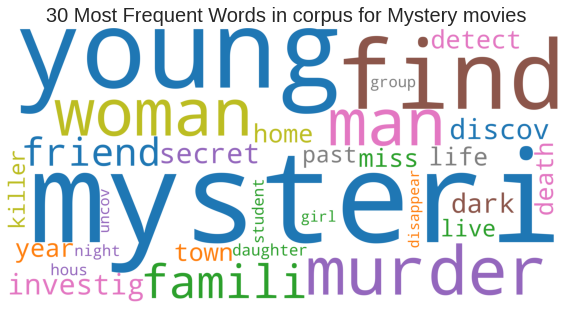

In [ ]:
df_wordcloud = df.loc[df['Mystery']==1, ['corpus']]
list_wordcloud = [x for x in df_wordcloud['corpus'].str.split()]
list_wordcloud = list(itertools.chain(*list_wordcloud))

plot_wordcloud = ' '.join(list_wordcloud)
plot_wordcloud = WordCloud(stopwords=stopwords, background_color='white', max_words = 30, height=2000, width=4000, random_state = 42, 
                           normalize_plurals = False, colormap='tab10').generate(plot_wordcloud)

fig, ax = plt.subplots(figsize=(10,6))
plt.imshow(plot_wordcloud)
plt.title('30 Most Frequent Words in corpus for Mystery movies', fontsize = 20)
plt.axis("off")
plt.show();

10. แสดง Word Cloud ประเภท Sci-Fi ไม่พบว่ามีคำที่ไม่น่าสื่อความหมายในการทำนายประเภทหนัง ดังภาพ

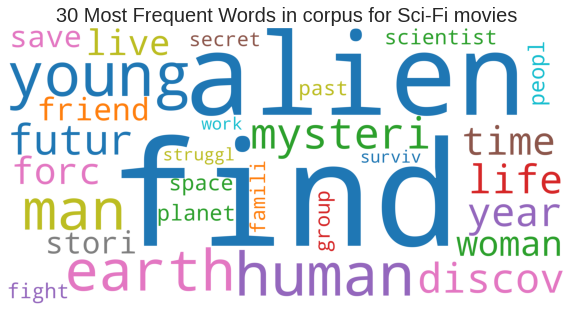

In [ ]:
df_wordcloud = df.loc[df['Sci-Fi']==1, ['corpus']]
list_wordcloud = [x for x in df_wordcloud['corpus'].str.split()]
list_wordcloud = list(itertools.chain(*list_wordcloud))

plot_wordcloud = ' '.join(list_wordcloud)
plot_wordcloud = WordCloud(stopwords=stopwords, background_color='white', max_words = 30, height=2000, width=4000, random_state = 42, 
                           normalize_plurals = False, colormap='tab10').generate(plot_wordcloud)

fig, ax = plt.subplots(figsize=(10,6))
plt.imshow(plot_wordcloud)
plt.title('30 Most Frequent Words in corpus for Sci-Fi movies', fontsize = 20)
plt.axis("off")
plt.show();

ต่อไปเก็บ stopwords ที่สร้างเหล่านี้ไปไว้ใน pickle เพื่อเรียกใช้งานต่อเนื่องอย่างรวดเร็ว โดยไม่ต้องผ่านการทำ WordCloud ที่มีการเก็บ stopwords แต่ละครั้งไว้

In [6]:
import pickle
# all_stopwords = stopwords

# with open('list_stopwords.pkl', 'wb') as f:
#     pickle.dump(all_stopwords, f)

with open('/content/drive/MyDrive/MSDS/Text Analytic/Movie Genre Classification/list_stopwords.pkl', 'rb') as f:
    all_stopwords = pickle.load(f)

## TFIDF Vetorization

ต่อไปจะสร้าง vector space model ในการทำ TFIDF โดยกำหนดพารามิเตอร์ stopwords โดยรวมถึง word ที่ไม่น่าสื่อความหมายจากการทำ EDA และ max features = 5000 (เนื่องจากรัน All features แล้วพบว่ามีค่า F1-score ใกล้เคียงกัน จึงลดจำนวน feature เพื่อ train model ให้เร็วขึ้น

In [7]:
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
new_stopwords = text.ENGLISH_STOP_WORDS.union(list(all_stopwords))
vectorizer_tfidf = TfidfVectorizer(stop_words=new_stopwords, max_features=5000)
tfidf = vectorizer_tfidf.fit_transform(corpus)

และกำหนด X เป็น feature ที่มีค่า TFIDF ของแต่ละ word ที่ได้มา และ y เป็น target สำหรับทำนายประเภทหนัง โดยทั้ง 2 ตัวแปรนี้มีรูปแบบเป็น array

In [138]:
X = tfidf.toarray()
y = df.iloc[:, 4:-1].values

จะได้ Dataset ที่มีจำนวน 11,476 เรื่อง, จำนวน 5,000 ฟีเจอร์ และจำนวน 10 target การทำนายประเภทหนัง

In [139]:
X.shape

(11476, 5000)

In [141]:
y.shape

(11476, 10)

## Splitting Dataset

แยกชุดข้อมูลออกเป็น Training set 80% และ Test set 20% จะได้จำนวนเรื่อง และ feature ด้านล่างนี้

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print('X_train size: {}, y_train size: {}, X_test size: {}, y_test size: {}'.format(X_train.shape, y_train.shape, X_test.shape, y_test.shape))

X_train size: (9180, 5000), y_train size: (9180, 10), X_test size: (2296, 5000), y_test size: (2296, 10)


## Classification without LDA

งานนี้ได้ทดลองสร้าง Model จำนวน 7 แบบ ดังนี้
1. Naive Bayes
2. Logistic Regression
3. K-Nearest Neighbour
4. Support Vector Machine
5. Decision Tree
6. Random Forest
7. XGBoost

ทั้งนี้ พบว่า Model ที่ train นานมาก คือ K-Nearest Neighbour, Support Vector Machine และ XGBoost จึงทำ Model ที่เหลือเพียง 4 แบบ ดังกล่าว

ส่วน Metrics ที่ใช้การทำนายคือ F1-score เนื่องจาก Accuracy score ให้ค่าที่ต่ำมาก ได้แก่ y_test = {0,0,1,1,0} หากได้ y_pred = {0,1,1,1,0} แม้ว่าทำนายผิดตัวเดียว จะถือว่าผิดเลย ทำให้ได้ TP และ TN ที่น้อยมาก แต่ F1-Score จะเทียบทีละ Class หากทายคลาส 1 ถูก คลาสที่เหลือไม่ถูก ก็จะนับเป็น TP ของ Class 1 ไม่สนใจ TN ทำให้ค่า F1-Score ที่ได้ดีกว่า Accuracy มาก ดังนั้น จึงเลือก F1-score ในการประเมินประสิทธิภาพของ Model


In [10]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, accuracy_score, classification_report

### Naive Bayes

In [ ]:
nb = MultiOutputClassifier(GaussianNB())
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)
sc_nb = f1_score(y_test, y_pred_nb, average='micro')
print('F1-score of Naive Bayes: ' + str(round(sc_nb*100, 2)) + '%')

F1-score of Naive Bayes: 37.5%


### Logistic Regression

In [11]:
lr = MultiOutputClassifier(LogisticRegression(random_state=42))
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
sc_lr = f1_score(y_test, y_pred_lr, average='micro')
print('F1-score of Logistic Regression: ' + str(round(sc_lr*100, 2)) + '%')

F1-score of Logistic Regression: 40.64%


### Decision Tree

In [ ]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
sc_dt = f1_score(y_test, y_pred_dt, average='micro')
print('F1-score of Decision Tree: ' + str(round(sc_dt*100, 2)) + '%')

F1-score of Decision Tree: 37.37%


### Random Forest

In [ ]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
sc_rf = f1_score(y_test, y_pred_rf, average='micro')
print('F1-score of Random Forest: ' + str(round(sc_rf*100, 2)) + '%')

F1-score of Random Forest: 37.5%


## Classification with LDA

สำหรับการทำ LDA จะกำหนด Topics จำนวน 30 เรื่องในการสร้าง Model 4 แบบดังกล่าว เนื่องจากรัน Model ที่มีจำนวน Topic 10, 20, 30, 40 เรื่อง แล้วพบว่า 30 Topics ให้ค่า F1-Score ดีที่สุด

In [12]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components=30, random_state=42)

X_train_lda = lda.fit_transform(X_train)
X_test_lda = lda.transform(X_test)

lda_components = lda.components_
terms = vectorizer_tfidf.get_feature_names()

for index, component in enumerate(lda_components):
    zipped = zip(terms, component)
    top_terms_key = sorted(zipped, key=lambda t: t[1], reverse=True)[:7]
    top_terms_list = list(dict(top_terms_key).keys())
    print("Topic "+str(index+1)+": ", top_terms_list)

Topic 1:  ['day', 'desert', 'small', 'smoke', 'disast', 'modern', 'wild']
Topic 2:  ['horror', 'killer', 'serial', 'tale', 'demon', 'group', 'featur']
Topic 3:  ['traffick', 'investig', 'human', 'murder', 'suicid', 'daughter', 'team']
Topic 4:  ['life', 'hometown', 'struggl', 'famili', 'forc', 'journey', 'trauma']
Topic 5:  ['lie', 'live', 'deeper', 'young', 'boyfriend', 'sick', 'shoot']
Topic 6:  ['home', 'life', 'man', 'love', 'return', 'famili', 'friend']
Topic 7:  ['justic', 'far', 'futur', 'human', 'mad', 'assassin', 'earth']
Topic 8:  ['young', 'stori', 'life', 'struggl', 'destruct', 'stand', 'church']
Topic 9:  ['love', 'live', 'man', 'young', 'ag', 'trip', 'home']
Topic 10:  ['miss', 'year', 'friend', 'murder', 'town', 'young', 'investig']
Topic 11:  ['life', 'fi', 'live', 'sci', 'man', 'love', 'young']
Topic 12:  ['pick', 'young', 'summer', 'trap', 'man', 'dark', 'lock']
Topic 13:  ['young', 'light', 'special', 'agent', 'oper', 'noir', 'friend']
Topic 14:  ['space', 'stori', '

### Naive Bayes

In [ ]:
nb_lda = MultiOutputClassifier(GaussianNB())
nb_lda.fit(X_train_lda, y_train)
y_pred_nb_lda = nb_lda.predict(X_test_lda)
sc_nb_lda = f1_score(y_test, y_pred_nb_lda, average='micro')
print('F1-score of Naive Bayes with LDA: ' + str(round(sc_nb_lda*100, 2)) + '%')

F1-score of Naive Bayes with LDA: 30.52%


### Logistic Regression

In [ ]:
lr_lda = MultiOutputClassifier(LogisticRegression(random_state=42))
lr_lda.fit(X_train_lda, y_train)
y_pred_lr_lda = lr_lda.predict(X_test_lda)
sc_lr_lda = f1_score(y_test, y_pred_lr_lda, average='micro')
print('F1-score of Logistic Regression with LDA: ' + str(round(sc_lr_lda*100, 2)) + '%')

F1-score of Logistic Regression with LDA: 9.52%


### Decision Tree

In [ ]:
dt_lda = DecisionTreeClassifier(random_state=42)
dt_lda.fit(X_train_lda, y_train)
y_pred_dt_lda = dt_lda.predict(X_test_lda)
sc_dt_lda = f1_score(y_test, y_pred_dt_lda, average='micro')
print('F1-score of Decision Tree with LDA: ' + str(round(sc_dt_lda*100, 2)) + '%')

F1-score of Decision Tree with LDA: 25.98%


### Random Forest

In [ ]:
rf_lda = RandomForestClassifier(random_state=42)
rf_lda.fit(X_train_lda, y_train)
y_pred_rf_lda = rf_lda.predict(X_test_lda)
sc_rf_lda = f1_score(y_test, y_pred_rf_lda, average='micro')
print('F1-score of Random Forest with LDA: ' + str(round(sc_rf_lda*100, 2)) + '%')

F1-score of Random Forest with LDA: 20.37%


## Comparison of the model's performance

เปรียบเทียบค่า F1-Score ของ Model ที่ไม่ได้ทำ LDA และ Model ที่ทำ LDA เพื่อเลือก Best Model จากการพิจารณา F1-Score ที่ดีที่สุด
* สำหรับ Classfication without LDA ที่ดีที่สุดคือ Logistic Regression มีค่า F1-Score เท่ากับ 40.64%
* สำหรับ Classfication with LDA ที่ดีที่สุดคือ NaiveBayes มีค่า F1-Score เท่ากับ 25.98%

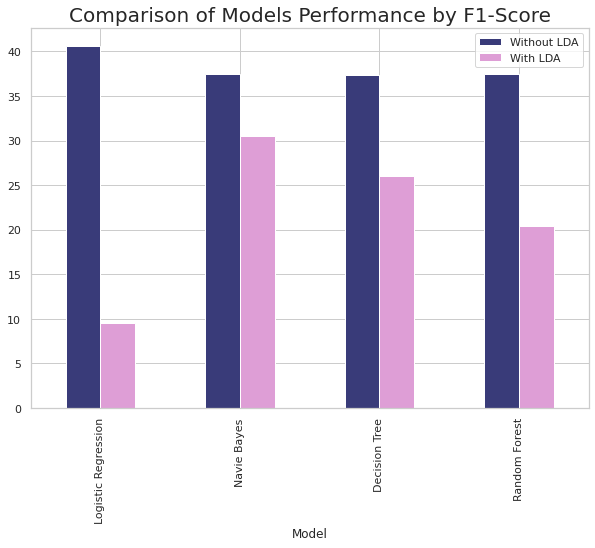

In [ ]:
results = pd.DataFrame({'Model': ["Logistic Regression", "Navie Bayes", "Decision Tree","Random Forest"],
                        'Without LDA': [sc_lr*100, sc_nb*100, sc_dt*100, sc_rf*100],
                        'With LDA': [sc_lr_lda*100, sc_nb_lda*100, sc_dt_lda*100, sc_rf_lda*100]})
results.plot(kind='bar', x='Model', figsize=(10,7), cmap='tab20b')
plt.title('Comparison of Models Performance by F1-Score', fontsize = 20);

## Analysis of Error

นำ Logistic Regression without LDA ที่ให้ผลลัพธ์ดีที่สุดนั้น ไปวิเคราะห์ Error ในการทำนายผิดพลาดและการทำนายถูกต้อง เพื่อหา text pattern โดยเริ่มจากการพิจารณา F1-Score

In [13]:
f1 = []
for i in range(X_test.shape[0]):
  f1.append(f1_score(y_test[i], y_pred_lr[i]))
print("Number of f1_score is", len(f1))
f1[:10]

Number of f1_score is 2296


[1.0,
 0.0,
 0.6666666666666666,
 0.0,
 1.0,
 0.0,
 0.6666666666666666,
 0.0,
 0.0,
 0.0]

### EDA of True Prediction

หาคำที่โดดเด่นที่สุดจำนวน 30 คำ จากการทำนายถูกต้อง โดยมีค่า F1-Score เท่ากับ 1 เพื่อหา text patterns โดยเริ่มจากการหา index ของ instance ที่ทำนายถูกต้อง เพื่อใช้สำหรับสร้าง DataFrame ของ index นั้นๆ ที่แสดงรายละเอียดของหนัง จากการสร้าง DataFrame อีกครั้ง เนื่องจาก X_train, X_test ที่ถูก split ครั้งแรกนั้น เป็น array ที่เป็นค่า TFIDF

In [94]:
index_f1_1 = [idx for idx, element in enumerate(f1) if element==1]
index_f1_1[:10]

[0, 4, 12, 15, 16, 28, 31, 35, 49, 50]

In [110]:
df_X_train, df_X_test, df_y_train, df_y_test = train_test_split(df[['movie','descriptions','corpus', 'Drama', 'Comedy', 'Horror', 'Thriller', 'Action', 'Crime', 'Romance', 'Adventure', 'Mystery', 'Sci-Fi']], df.iloc[:, 4:-1].values, test_size=0.2, random_state=42)
df_X_test_f1_1 = df_X_test.iloc[index_f1_1,:]

จากภาพ WordCloud ที่ทำนายถูกต้องด้านล่าง พบว่าคำที่โดดเด่นคือ young, find, young

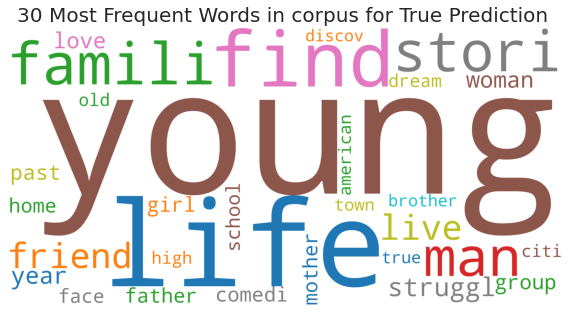

In [107]:
import itertools
from wordcloud import WordCloud, STOPWORDS

list_wordcloud = [x for x in df_X_test_f1_1['corpus'].str.split()]
list_wordcloud = list(itertools.chain(*list_wordcloud))

plot_wordcloud = ' '.join(list_wordcloud)
plot_wordcloud = WordCloud(stopwords=all_stopwords, background_color='white', max_words = 30, height=2000, width=4000, random_state = 42, 
                           normalize_plurals = False, colormap='tab10').generate(plot_wordcloud)

fig, ax = plt.subplots(figsize=(10,6))
plt.imshow(plot_wordcloud)
plt.title('30 Most Frequent Words in corpus for True Prediction ', fontsize = 20)
plt.axis("off")
plt.show();

แสดง text ใน description หนังทั้งหมดที่มีคำโดดเด่นว่า young สำหรับการทำนายถูก

In [147]:
word_horror = df_X_test_f1_1['corpus'].str.contains("young")
df_X_test_f1_1.loc[word_horror, 'descriptions'].values[:10].tolist()

["A young girl's life is turned upside down when she encounters a traumatic event and has to embrace forgiveness and an unlikely friendship to break a generational curse.",
 'An unrelenting young man sets out to decipher the world around him through an improvised yet secretly autobiographical short film he makes in the midst of an existential crisis.',
 "A young couple thinks they've found paradise in the luxury home they've just purchased in the Arizona desert but something lurks below the surface. This thriller-horror will leave you thirsting for more.",
 'A coming of age comedy about a young man in his final years of college that returns home to Massachusetts for his summer break. While there he ends up back at his old job working at a local...                See full summary\xa0»',
 "A Young Man can't hide too many things Surrounding him.",
 'When police officers (Josh Liebelt and Tyler Eagan) are called to a horrific murder, they discover a young boy murdered in cold blood and nea

ต่อไปหาคำโดดเด่นในการทำนายถูกในรูปแบบ WordCloud ของแต่ละ genre ว่าเป็นยังไง โดยเริ่มจากการพิจารณา genre ที่มีในการทำนายถูกต้อง ซึ่งมีค่าแท้ y_test และค่าทำนาย y_pred_lr เท่ากับ 1

In [119]:
true_drama = []
for i in range(X_test.shape[0]):
  true_drama.append(1 if y_test[i,0]==y_pred_lr[i,0]==1 else 0)
print(true_drama[:20])

index_true_drama = [idx for idx, element in enumerate(true_drama) if element==1]
print(index_true_drama[:10])

df_X_test_true_drama = df_X_test.iloc[index_true_drama,:]

[1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0]
[0, 6, 15, 16, 20, 21, 31, 32, 49, 50]


In [121]:
true_comedy = []
for i in range(X_test.shape[0]):
  true_comedy.append(1 if y_test[i,1]==y_pred_lr[i,1]==1 else 0)
index_true_comedy = [idx for idx, element in enumerate(true_comedy) if element==1]
df_X_test_true_comedy = df_X_test.iloc[index_true_comedy,:]

true_horror = []
for i in range(X_test.shape[0]):
  true_horror.append(1 if y_test[i,2]==y_pred_lr[i,2]==1 else 0)
index_true_horror = [idx for idx, element in enumerate(true_horror) if element==1]
df_X_test_true_horror = df_X_test.iloc[index_true_horror,:]

true_thriller = []
for i in range(X_test.shape[0]):
  true_thriller.append(1 if y_test[i,3]==y_pred_lr[i,3]==1 else 0)
index_true_thriller = [idx for idx, element in enumerate(true_thriller) if element==1]
df_X_test_true_thriller = df_X_test.iloc[index_true_thriller,:]

true_action = []
for i in range(X_test.shape[0]):
  true_action.append(1 if y_test[i,4]==y_pred_lr[i,4]==1 else 0)
index_true_action = [idx for idx, element in enumerate(true_action) if element==1]
df_X_test_true_action = df_X_test.iloc[index_true_action,:]

true_crime = []
for i in range(X_test.shape[0]):
  true_crime.append(1 if y_test[i,5]==y_pred_lr[i,5]==1 else 0)
index_true_crime = [idx for idx, element in enumerate(true_crime) if element==1]
df_X_test_true_crime = df_X_test.iloc[index_true_crime,:]

true_romance = []
for i in range(X_test.shape[0]):
  true_romance.append(1 if y_test[i,6]==y_pred_lr[i,6]==1 else 0)
index_true_romance = [idx for idx, element in enumerate(true_romance) if element==1]
df_X_test_true_romance = df_X_test.iloc[index_true_romance,:]

true_adventure = []
for i in range(X_test.shape[0]):
  true_adventure.append(1 if y_test[i,7]==y_pred_lr[i,7]==1 else 0)
index_true_adventure = [idx for idx, element in enumerate(true_adventure) if element==1]
df_X_test_true_adventure = df_X_test.iloc[index_true_adventure,:]

true_mystery = []
for i in range(X_test.shape[0]):
  true_mystery.append(1 if y_test[i,8]==y_pred_lr[i,8]==1 else 0)
index_true_mystery = [idx for idx, element in enumerate(true_mystery) if element==1]
df_X_test_true_mystery = df_X_test.iloc[index_true_mystery,:]

true_scifi = []
for i in range(X_test.shape[0]):
  true_scifi.append(1 if y_test[i,9]==y_pred_lr[i,9]==1 else 0)
index_true_scifi = [idx for idx, element in enumerate(true_scifi) if element==1]
df_X_test_true_scifi = df_X_test.iloc[index_true_scifi,:]

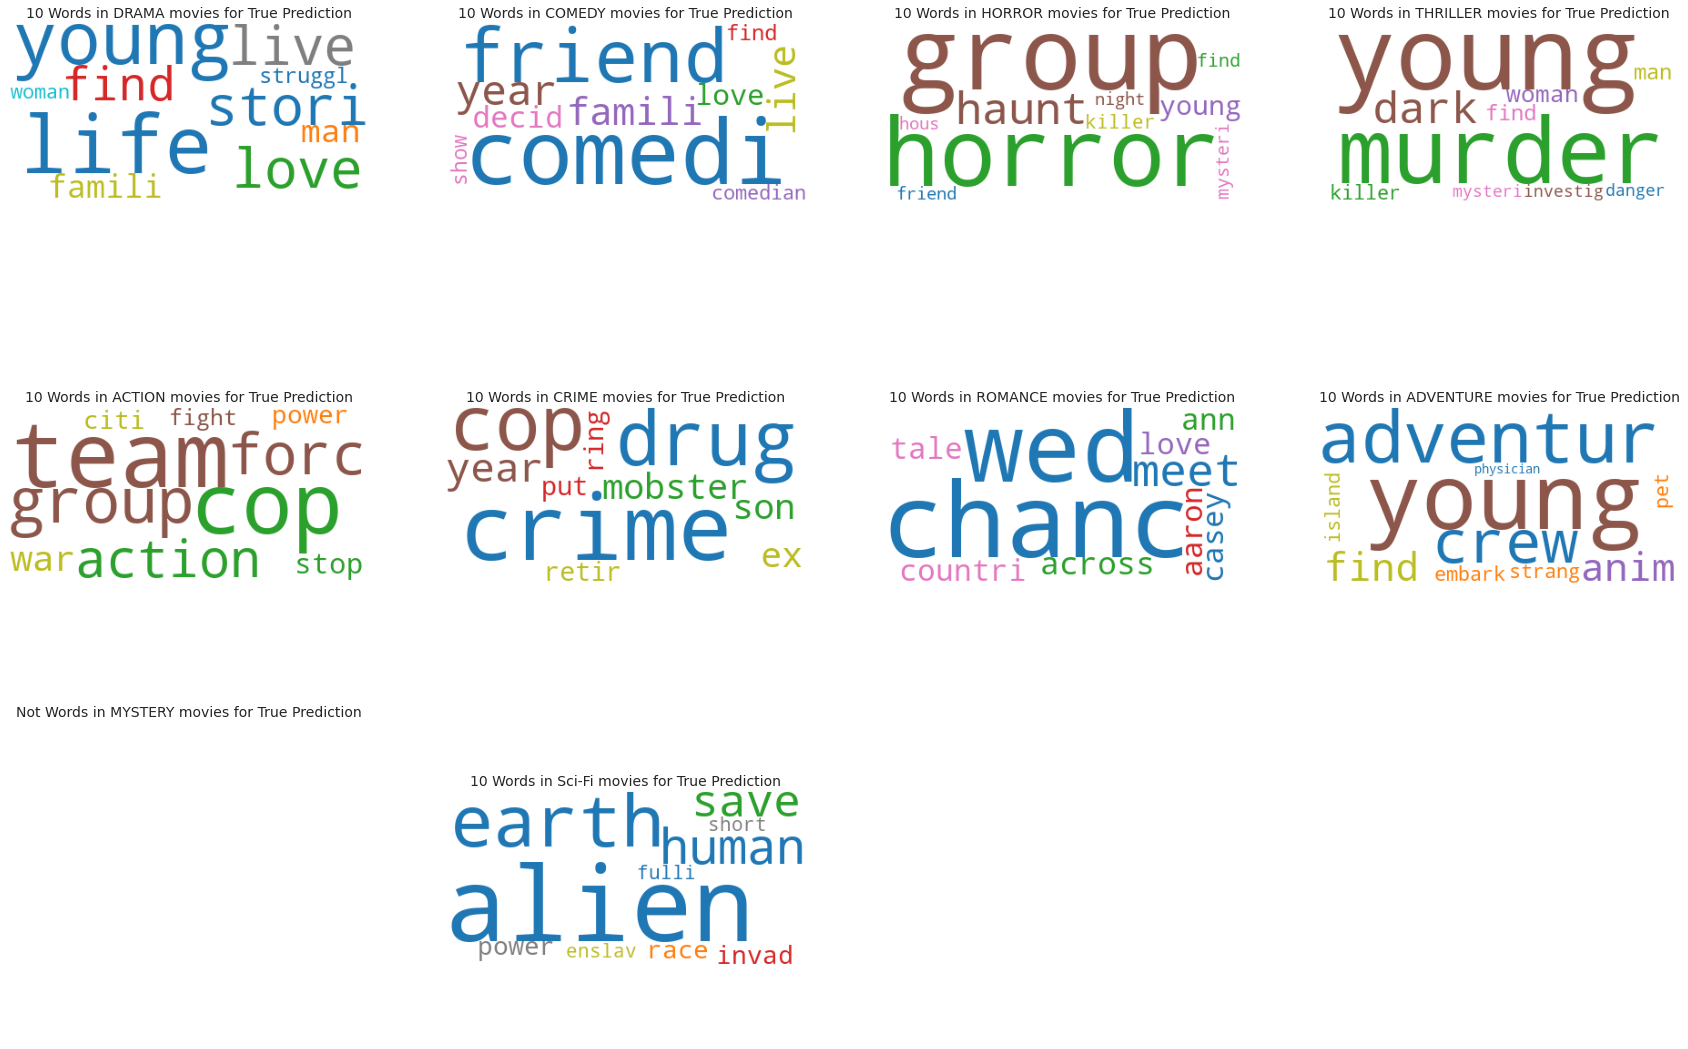

In [125]:
import itertools
from wordcloud import WordCloud, STOPWORDS

fig, ax = plt.subplots(figsize=(30,20))

plt.subplot(341)
list_wordcloud = [x for x in df_X_test_true_drama['corpus'].str.split()]
list_wordcloud = list(itertools.chain(*list_wordcloud))
plot_wordcloud = ' '.join(list_wordcloud)
plot_wordcloud = WordCloud(stopwords=all_stopwords, background_color='white', max_words = 10, random_state = 42, 
                           normalize_plurals = False, colormap='tab10').generate(plot_wordcloud)
plt.imshow(plot_wordcloud)
plt.title("10 Words in DRAMA movies for True Prediction", fontsize=14)
plt.axis("off")

plt.subplot(342)
list_wordcloud = [x for x in df_X_test_true_comedy['corpus'].str.split()]
list_wordcloud = list(itertools.chain(*list_wordcloud))
plot_wordcloud = ' '.join(list_wordcloud)
plot_wordcloud = WordCloud(stopwords=all_stopwords, background_color='white', max_words = 10, random_state = 42, 
                           normalize_plurals = False, colormap='tab10').generate(plot_wordcloud)
plt.imshow(plot_wordcloud)
plt.title("10 Words in COMEDY movies for True Prediction", fontsize=14)
plt.axis("off")

plt.subplot(343)
list_wordcloud = [x for x in df_X_test_true_horror['corpus'].str.split()]
list_wordcloud = list(itertools.chain(*list_wordcloud))
plot_wordcloud = ' '.join(list_wordcloud)
plot_wordcloud = WordCloud(stopwords=all_stopwords, background_color='white', max_words = 10, random_state = 42, 
                           normalize_plurals = False, colormap='tab10').generate(plot_wordcloud)
plt.imshow(plot_wordcloud)
plt.title("10 Words in HORROR movies for True Prediction", fontsize=14)
plt.axis("off")

plt.subplot(344)
list_wordcloud = [x for x in df_X_test_true_thriller['corpus'].str.split()]
list_wordcloud = list(itertools.chain(*list_wordcloud))
plot_wordcloud = ' '.join(list_wordcloud)
plot_wordcloud = WordCloud(stopwords=all_stopwords, background_color='white', max_words = 10, random_state = 42, 
                           normalize_plurals = False, colormap='tab10').generate(plot_wordcloud)
plt.imshow(plot_wordcloud)
plt.title("10 Words in THRILLER movies for True Prediction", fontsize=14)
plt.axis("off")

plt.subplot(345)
list_wordcloud = [x for x in df_X_test_true_action['corpus'].str.split()]
list_wordcloud = list(itertools.chain(*list_wordcloud))
plot_wordcloud = ' '.join(list_wordcloud)
plot_wordcloud = WordCloud(stopwords=all_stopwords, background_color='white', max_words = 10, random_state = 42, 
                           normalize_plurals = False, colormap='tab10').generate(plot_wordcloud)
plt.imshow(plot_wordcloud)
plt.title("10 Words in ACTION movies for True Prediction", fontsize=14)
plt.axis("off")

plt.subplot(346)
list_wordcloud = [x for x in df_X_test_true_crime['corpus'].str.split()]
list_wordcloud = list(itertools.chain(*list_wordcloud))
plot_wordcloud = ' '.join(list_wordcloud)
plot_wordcloud = WordCloud(stopwords=all_stopwords, background_color='white', max_words = 10, random_state = 42, 
                           normalize_plurals = False, colormap='tab10').generate(plot_wordcloud)
plt.imshow(plot_wordcloud)
plt.title("10 Words in CRIME movies for True Prediction", fontsize=14)
plt.axis("off")

plt.subplot(347)
list_wordcloud = [x for x in df_X_test_true_romance['corpus'].str.split()]
list_wordcloud = list(itertools.chain(*list_wordcloud))
plot_wordcloud = ' '.join(list_wordcloud)
plot_wordcloud = WordCloud(stopwords=all_stopwords, background_color='white', max_words = 10, random_state = 42, 
                           normalize_plurals = False, colormap='tab10').generate(plot_wordcloud)
plt.imshow(plot_wordcloud)
plt.title("10 Words in ROMANCE movies for True Prediction", fontsize=14)
plt.axis("off")

plt.subplot(348)
list_wordcloud = [x for x in df_X_test_true_adventure['corpus'].str.split()]
list_wordcloud = list(itertools.chain(*list_wordcloud))
plot_wordcloud = ' '.join(list_wordcloud)
plot_wordcloud = WordCloud(stopwords=all_stopwords, background_color='white', max_words = 10, random_state = 42, 
                           normalize_plurals = False, colormap='tab10').generate(plot_wordcloud)
plt.imshow(plot_wordcloud)
plt.title("10 Words in ADVENTURE movies for True Prediction", fontsize=14)
plt.axis("off")

plt.subplot(349)
# list_wordcloud = [x for x in df_X_test_true_mystery['corpus'].str.split()]
# list_wordcloud = list(itertools.chain(*list_wordcloud))
# plot_wordcloud = ' '.join(list_wordcloud)
# plot_wordcloud = WordCloud(stopwords=all_stopwords, background_color='white', max_words = 10, random_state = 42, 
#                            normalize_plurals = False, colormap='tab10').generate(plot_wordcloud)
# plt.imshow(plot_wordcloud)
plt.title("Not Words in MYSTERY movies for True Prediction", fontsize=14)
plt.axis("off")

fig.add_subplot(3, 4, 10)
list_wordcloud = [x for x in df_X_test_true_scifi['corpus'].str.split()]
list_wordcloud = list(itertools.chain(*list_wordcloud))
plot_wordcloud = ' '.join(list_wordcloud)
plot_wordcloud = WordCloud(stopwords=all_stopwords, background_color='white', max_words = 10, random_state = 42, 
                           normalize_plurals = False, colormap='tab10').generate(plot_wordcloud)
plt.imshow(plot_wordcloud)
plt.title("10 Words in Sci-Fi movies for True Prediction", fontsize=14)
plt.axis("off")

plt.show();

### EDA of False Prediction

หาคำที่โดดเด่นที่สุดจำนวน 30 คำ จากการทำนายผิดพลาด โดยไม่มีค่า F1-Score เพื่อหา text patterns โดยเริ่มจากการหา index ของ instance ที่ทำนายผิด เพื่อใช้สำหรับสร้าง DataFrame ของ index นั้นๆ ที่แสดงรายละเอียดของหนัง

In [14]:
index_f1_0 = [idx for idx, element in enumerate(f1) if element==0]
index_f1_0[:10]

[1, 3, 5, 7, 8, 9, 10, 17, 18, 19]

แสดง DataFrame ของ instance ใน test set ที่ทำนายผิด ซึ่งไม่มีค่า F1-score

In [108]:
df_X_test_f1_0 = df_X_test.iloc[index_f1_0,:]
df_X_test_f1_0['descriptions'] = df_X_test_f1_0['descriptions'].str.strip()
df_X_test_f1_0[['movie', 'descriptions', 'corpus', 'Drama', 'Comedy', 'Horror', 'Thriller', 'Action', 'Crime', 'Romance', 'Adventure', 'Mystery', 'Sci-Fi']]

,movie,descriptions,corpus,Drama,Comedy,Horror,Thriller,Action,Crime,Romance,Adventure,Mystery,Sci-Fi
7905,The Bone Box,A grave robber comes to believe he's being hau...,come haunt grave believ robber stole,1,0,1,1,0,0,0,0,0,0
1934,Permeation,A dark and gritty film by Arius Blaze. Daemon ...,jeffrey daemon word obsess gritti buildingth d...,0,0,0,1,0,0,0,0,0,0
468,Bounty Nation,"Buffalo Buford, a career bounty hunter and pri...",hunter career buford pacif bounti trek northwe...,0,1,0,0,0,0,0,0,0,0
4924,Ring Ring,After a group of telemarketers gets fired by t...,boss reveng steal group heat firm penny-pinch ...,0,0,0,1,1,0,0,0,0,0
651,Coney Island,A group of cones living on Coney Island naviga...,cone relationship group world behind futur nav...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5303,The Deadbeats,"Mr. Patch, the Magical Pirate Clown, is harass...",harass break pirat magic patch mr point violen...,0,0,0,1,0,0,0,0,0,0
6147,Beautiful Lust,"Beautiful Lust, is a visual testimony of how t...",testimoni slaveri visual deliv yashaq beauti b...,1,0,0,0,0,0,0,0,0,0
5426,The Kupid Killer,A thriller about a man looking for love but th...,determin look man love meet thriller live wome...,0,0,0,1,0,0,0,0,0,0
3184,¡He matado a mi marido!,A desperate woman accidentally murders her unf...,unfaith night prize woman big honor without mu...,0,1,0,0,0,1,1,0,0,0


จากภาพ WordCloud ที่ทำนายผิดด้านล่าง พบว่าคำที่โดดเด่นคือ find, young, life เช่นเดียวกับการทำนายถูกต้องด้านบน แสดงว่าน่าจะเป็น stopword ที่อาจจะตัดออกไปได้ จากการที่ไม่ได้ตัดคำเหล่านี้ออกไปตั้งแต่แรก เนื่องจาก stopword อาจจะเป็นคำที่สำคัญก็ได้ จึงทำ EDA ให้ดีก่อนตัด stopword ที่ไม่มีผลอะไรจริงๆ สรุปว่าสามารถตัดคำเหล่านี้ออกไปได้

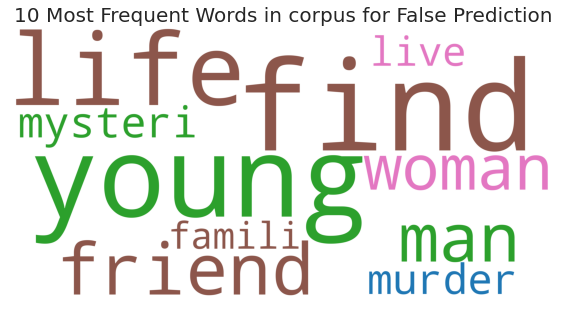

In [142]:
list_wordcloud = [x for x in df_X_test_f1_0['corpus'].str.split()]
list_wordcloud = list(itertools.chain(*list_wordcloud))

plot_wordcloud = ' '.join(list_wordcloud)
plot_wordcloud = WordCloud(stopwords=all_stopwords, background_color='white', max_words = 10, height=4000, width=8000, random_state = 42, 
                           normalize_plurals = False, colormap='tab10').generate(plot_wordcloud)

fig, ax = plt.subplots(figsize=(10,6))
plt.imshow(plot_wordcloud)
plt.title('10 Most Frequent Words in corpus for False Prediction ', fontsize = 20)
plt.axis("off")
plt.show();

แสดง text ใน description หนังทั้งหมดที่มีคำโดดเด่นว่า find สำหรับการทำนายถูก

In [148]:
word_find = df_X_test_f1_0['corpus'].str.contains("find")
df_X_test_f1_0.loc[word_find, 'descriptions'].values[:20].tolist()

['A dark and gritty film by Arius Blaze. Daemon (Jeffrey Arrington) finds himself in limbo in an old decaying apartment building.The only way out is through an obsession with the written word...                See full summary\xa0»',
 'The Black Tiger is responsible for multiple assassinations. When a survivor seeks vengeance, the Tiger finds himself in front of the firing squad. In a mixture of James Bond and The Streetfighter, this action/thriller is sure to please.',
 'After his estranged brother contacts him for help, a man and his girlfriend answer the call, only to find themselves unwittingly dragged into a murderous plot with severe consequences.',
 'Ten strangers find themselves trapped in the dark, in the storm, lost in huge fields of corn. They take refuge in a dark, quiet farmhouse where the welcoming Mr. Grant lives. But as the ...                See full summary\xa0»',
 'When a single mother accepts the help of a mysterious woman after her daughter is bitten by a rattlesna

ต่อไปหาคำโดดเด่นในการทำนายผิดในรูปแบบ WordCloud ของแต่ละ genre ว่าเป็นยังไง โดยเริ่มจากการพิจารณา genre ที่ทำนายไม่ตรงกับ genre แท้ ใน 2 กรณี คือ
* กรณีที่ 1 ค่าแท้ y_test เท่ากับ 1 กับค่าทำนาย y_pred_lr เท่ากับ 0 
* กรณีที่ 2 ค่าแท้ y_test เท่ากับ 0 กับค่าทำนาย y_pred_lr เท่ากับ 1 

ดังนั้น กำหนดเงื่อนไขการทำนายผิดของประเภทนั้นๆ โดยกำหนดค่าเท่ากับ 1 หากได้ค่าทำนายที่ไม่ตรงกับค่าแท้ และหา Index ของค่า 1 นี้ เพื่อนำ Index ไปหา sample ใน corpus ที่ Dataframe สำหรับทำ Wordcloud

โดยแสดงตัวอย่างการหา index ที่ทำนาย Drama ผิด จากการพิจารณาค่าเท่ากับ 1 ที่กำหนดเงื่อนไขดังกล่าว ซึ่งค่าที่ทำนายผิดเหล่านี้จะอยู่ Index ที่ 1, 3, 5, 8, ... ด้านล่างนี้

In [143]:
false_drama = []
for i in range(X_test.shape[0]):
  false_drama.append(1 if y_test[i,0]!=y_pred_lr[i,0] else 0)
print(false_drama[:20])

index_false_drama = [idx for idx, element in enumerate(false_drama) if element==1]
print(index_false_drama[:10])

df_X_test_false_drama = df_X_test.iloc[index_false_drama,:]

[0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 3, 5, 8, 26, 30, 34, 36, 39, 42]


ต่อไปทำการหา  index ที่ทำนายประเภทที่เหลือผิดของแต่ละประเภท โดยใช้วิธีเดียวกับ Drama ด้านบน

In [136]:
false_comedy = []
for i in range(X_test.shape[0]):
  false_comedy.append(1 if y_test[i,1]!=y_pred_lr[i,1] else 0)
index_false_comedy = [idx for idx, element in enumerate(false_comedy) if element==1]
df_X_test_false_comedy = df_X_test.iloc[index_false_comedy,:]

false_horror = []
for i in range(X_test.shape[0]):
  false_horror.append(1 if y_test[i,2]!=y_pred_lr[i,2] else 0)
index_false_horror = [idx for idx, element in enumerate(false_horror) if element==1]
df_X_test_false_horror = df_X_test.iloc[index_false_horror,:]

false_thriller = []
for i in range(X_test.shape[0]):
  false_thriller.append(1 if y_test[i,3]!=y_pred_lr[i,3] else 0)
index_false_thriller = [idx for idx, element in enumerate(false_thriller) if element==1]
df_X_test_false_thriller = df_X_test.iloc[index_false_thriller,:]

false_action = []
for i in range(X_test.shape[0]):
  false_action.append(1 if y_test[i,4]!=y_pred_lr[i,4] else 0)
index_false_action = [idx for idx, element in enumerate(false_action) if element==1]
df_X_test_false_action = df_X_test.iloc[index_false_action,:]

false_crime = []
for i in range(X_test.shape[0]):
  false_crime.append(1 if y_test[i,5]!=y_pred_lr[i,5] else 0)
index_false_crime = [idx for idx, element in enumerate(false_crime) if element==1]
df_X_test_false_crime = df_X_test.iloc[index_false_crime,:]

false_romance = []
for i in range(X_test.shape[0]):
  false_romance.append(1 if y_test[i,6]!=y_pred_lr[i,6] else 0)
index_false_romance = [idx for idx, element in enumerate(false_romance) if element==1]
df_X_test_false_romance = df_X_test.iloc[index_false_romance,:]

false_adventure = []
for i in range(X_test.shape[0]):
  false_adventure.append(1 if y_test[i,7]!=y_pred_lr[i,7] else 0)
index_false_adventure = [idx for idx, element in enumerate(false_adventure) if element==1]
df_X_test_false_adventure = df_X_test.iloc[index_false_adventure,:]

false_mystery = []
for i in range(X_test.shape[0]):
  false_mystery.append(1 if y_test[i,8]!=y_pred_lr[i,8] else 0)
index_false_mystery = [idx for idx, element in enumerate(false_mystery) if element==1]
df_X_test_false_mystery = df_X_test.iloc[index_false_mystery,:]

false_scifi = []
for i in range(X_test.shape[0]):
  false_scifi.append(1 if y_test[i,9]!=y_pred_lr[i,9] else 0)
index_false_scifi = [idx for idx, element in enumerate(false_scifi) if element==1]
df_X_test_false_scifi = df_X_test.iloc[index_false_scifi,:]

แสดง WordCloud ที่ทำนายประเภทผิด แต่ละประเภท ด้านล่างนี้

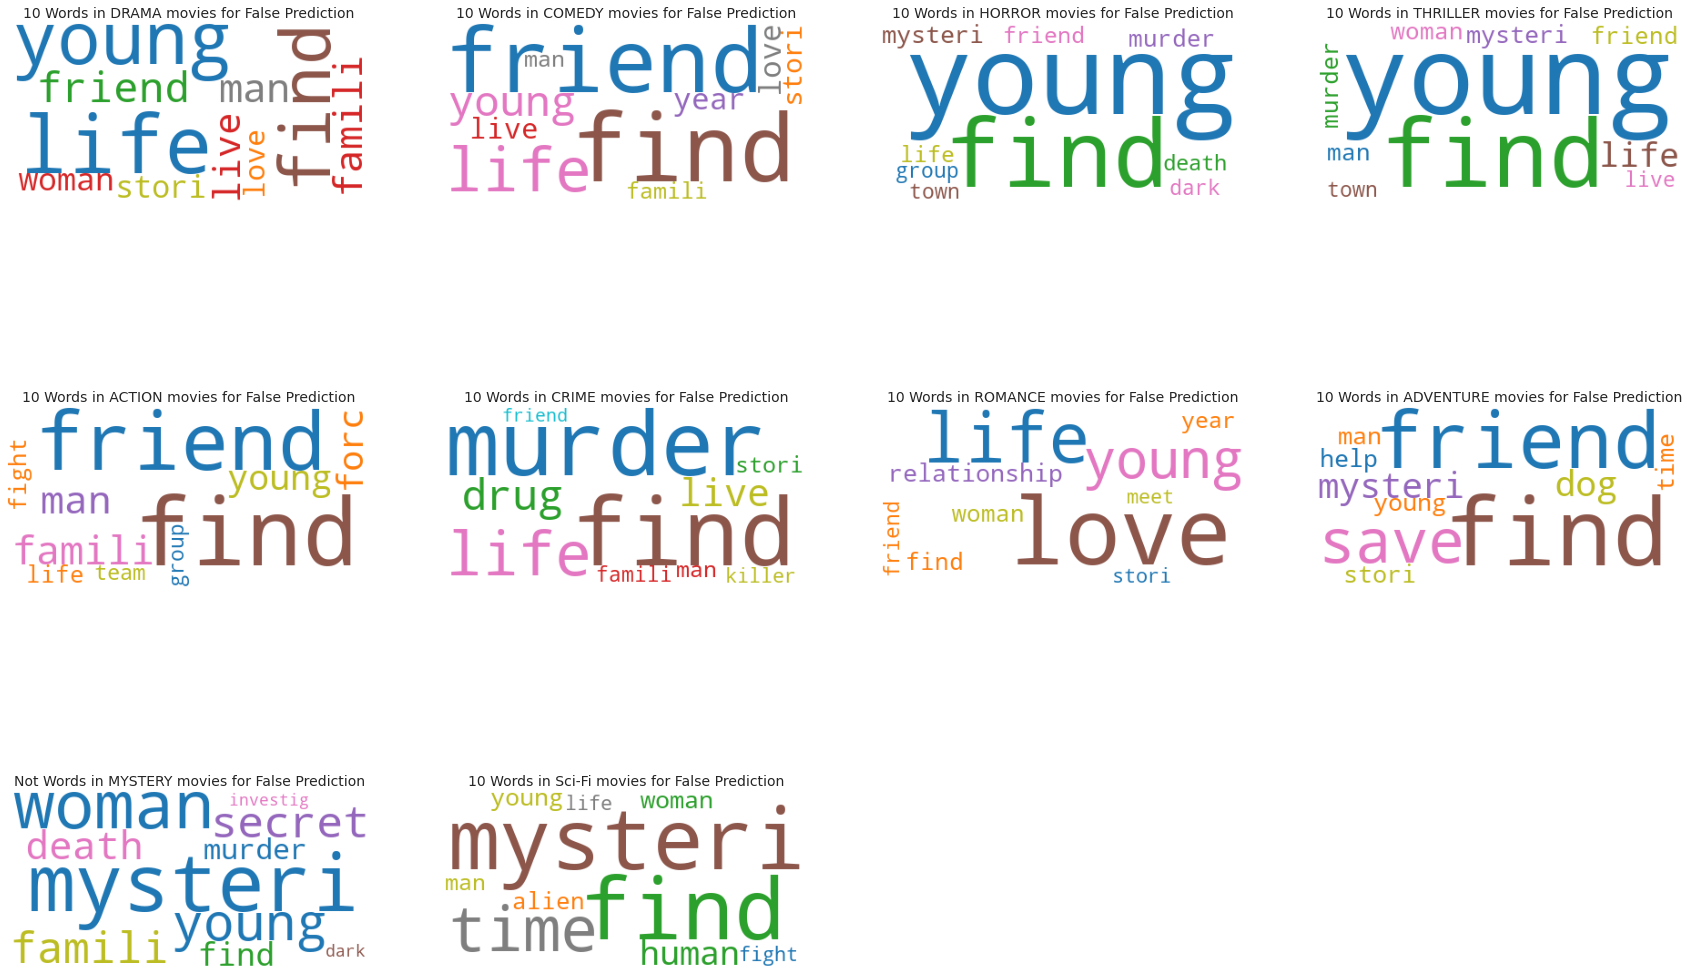

In [137]:
import itertools
from wordcloud import WordCloud, STOPWORDS

fig, ax = plt.subplots(figsize=(30,20))

plt.subplot(341)
list_wordcloud = [x for x in df_X_test_false_drama['corpus'].str.split()]
list_wordcloud = list(itertools.chain(*list_wordcloud))
plot_wordcloud = ' '.join(list_wordcloud)
plot_wordcloud = WordCloud(stopwords=all_stopwords, background_color='white', max_words = 10, random_state = 42, 
                           normalize_plurals = False, colormap='tab10').generate(plot_wordcloud)
plt.imshow(plot_wordcloud)
plt.title("10 Words in DRAMA movies for False Prediction", fontsize=14)
plt.axis("off")

plt.subplot(342)
list_wordcloud = [x for x in df_X_test_false_comedy['corpus'].str.split()]
list_wordcloud = list(itertools.chain(*list_wordcloud))
plot_wordcloud = ' '.join(list_wordcloud)
plot_wordcloud = WordCloud(stopwords=all_stopwords, background_color='white', max_words = 10, random_state = 42, 
                           normalize_plurals = False, colormap='tab10').generate(plot_wordcloud)
plt.imshow(plot_wordcloud)
plt.title("10 Words in COMEDY movies for False Prediction", fontsize=14)
plt.axis("off")

plt.subplot(343)
list_wordcloud = [x for x in df_X_test_false_horror['corpus'].str.split()]
list_wordcloud = list(itertools.chain(*list_wordcloud))
plot_wordcloud = ' '.join(list_wordcloud)
plot_wordcloud = WordCloud(stopwords=all_stopwords, background_color='white', max_words = 10, random_state = 42, 
                           normalize_plurals = False, colormap='tab10').generate(plot_wordcloud)
plt.imshow(plot_wordcloud)
plt.title("10 Words in HORROR movies for False Prediction", fontsize=14)
plt.axis("off")

plt.subplot(344)
list_wordcloud = [x for x in df_X_test_false_thriller['corpus'].str.split()]
list_wordcloud = list(itertools.chain(*list_wordcloud))
plot_wordcloud = ' '.join(list_wordcloud)
plot_wordcloud = WordCloud(stopwords=all_stopwords, background_color='white', max_words = 10, random_state = 42, 
                           normalize_plurals = False, colormap='tab10').generate(plot_wordcloud)
plt.imshow(plot_wordcloud)
plt.title("10 Words in THRILLER movies for False Prediction", fontsize=14)
plt.axis("off")

plt.subplot(345)
list_wordcloud = [x for x in df_X_test_false_action['corpus'].str.split()]
list_wordcloud = list(itertools.chain(*list_wordcloud))
plot_wordcloud = ' '.join(list_wordcloud)
plot_wordcloud = WordCloud(stopwords=all_stopwords, background_color='white', max_words = 10, random_state = 42, 
                           normalize_plurals = False, colormap='tab10').generate(plot_wordcloud)
plt.imshow(plot_wordcloud)
plt.title("10 Words in ACTION movies for False Prediction", fontsize=14)
plt.axis("off")

plt.subplot(346)
list_wordcloud = [x for x in df_X_test_false_crime['corpus'].str.split()]
list_wordcloud = list(itertools.chain(*list_wordcloud))
plot_wordcloud = ' '.join(list_wordcloud)
plot_wordcloud = WordCloud(stopwords=all_stopwords, background_color='white', max_words = 10, random_state = 42, 
                           normalize_plurals = False, colormap='tab10').generate(plot_wordcloud)
plt.imshow(plot_wordcloud)
plt.title("10 Words in CRIME movies for False Prediction", fontsize=14)
plt.axis("off")

plt.subplot(347)
list_wordcloud = [x for x in df_X_test_false_romance['corpus'].str.split()]
list_wordcloud = list(itertools.chain(*list_wordcloud))
plot_wordcloud = ' '.join(list_wordcloud)
plot_wordcloud = WordCloud(stopwords=all_stopwords, background_color='white', max_words = 10, random_state = 42, 
                           normalize_plurals = False, colormap='tab10').generate(plot_wordcloud)
plt.imshow(plot_wordcloud)
plt.title("10 Words in ROMANCE movies for False Prediction", fontsize=14)
plt.axis("off")

plt.subplot(348)
list_wordcloud = [x for x in df_X_test_false_adventure['corpus'].str.split()]
list_wordcloud = list(itertools.chain(*list_wordcloud))
plot_wordcloud = ' '.join(list_wordcloud)
plot_wordcloud = WordCloud(stopwords=all_stopwords, background_color='white', max_words = 10, random_state = 42, 
                           normalize_plurals = False, colormap='tab10').generate(plot_wordcloud)
plt.imshow(plot_wordcloud)
plt.title("10 Words in ADVENTURE movies for False Prediction", fontsize=14)
plt.axis("off")

plt.subplot(349)
list_wordcloud = [x for x in df_X_test_false_mystery['corpus'].str.split()]
list_wordcloud = list(itertools.chain(*list_wordcloud))
plot_wordcloud = ' '.join(list_wordcloud)
plot_wordcloud = WordCloud(stopwords=all_stopwords, background_color='white', max_words = 10, random_state = 42, 
                           normalize_plurals = False, colormap='tab10').generate(plot_wordcloud)
plt.imshow(plot_wordcloud)
plt.title("Not Words in MYSTERY movies for False Prediction", fontsize=14)
plt.axis("off")

fig.add_subplot(3, 4, 10)
list_wordcloud = [x for x in df_X_test_false_scifi['corpus'].str.split()]
list_wordcloud = list(itertools.chain(*list_wordcloud))
plot_wordcloud = ' '.join(list_wordcloud)
plot_wordcloud = WordCloud(stopwords=all_stopwords, background_color='white', max_words = 10, random_state = 42, 
                           normalize_plurals = False, colormap='tab10').generate(plot_wordcloud)
plt.imshow(plot_wordcloud)
plt.title("10 Words in Sci-Fi movies for False Prediction", fontsize=14)
plt.axis("off")

plt.show();

## Apply Best model (Logistic Regression without LDA) to the new text

นำ text อันใหม่ที่เป็น description หนัง เข้าสู่ Model ที่ดีที่สุดที่ได้จากการทดลองหลายแบบ (Logistic Regression without LDA) เพื่อทำนายว่า text นี้อยู่ประเภทหนังใดบ้าง โดยเริ่มจากนำ text นี้ไปทำความสะอาดในการแบ่งคำ

### New description 1 from Teacher Ratchainant

In [ ]:
text = "His life will be changed forever from love in wars."
text = re.sub("[,\/.!?():;$%&*@#^+=~_{}<>`]", '', text)
text = word_tokenize(text)
text = stopword_removal(text)
text = lemmatization(text)
text = number_removal(text)
text

['life', 'chang', 'forev', 'love', 'hi', 'war']

ต่อไปจะสร้าง DataFrame ให้กับ text นี้ เพื่อสร้าง Feature ให้มีจำนวนเท่ากับ feature ที่ได้จากการสร้างตัวแปร corpus ซึ่งมีการกำหนดจำนวน max feature เท่ากับ 5000 ตามพารามิเตอร์ใน TFIDF นั้น และใส่ค่า 1 ให้กับ word ที่มีใน tex นี้ใน 5000 features

In [ ]:
vocab = vectorizer_tfidf.get_feature_names()
len(vocab)

5000

In [ ]:
X_new = pd.DataFrame(index=vocab).transpose()
X_new.loc['new_text'] = 0
X_new[text] = 1
X_new

,aaron,abandon,abbey,abbi,abduct,abductor,abe,abil,abl,aboard,abort,abroad,abruptli,absenc,absolut,absorb,absurd,abus,abyss,academ,academi,accept,access,accid,accident,acclaim,accompani,accomplish,accord,account,accur,accus,ace,achiev,acquaint,acquir,act,action,activ,activist,...,wrath,wreak,wreck,wrench,wrestl,wrestler,wright,writ,write,writer,writerdirector,written,wrong,wrongli,ww,wwii,wyatt,wynn,yakuza,yale,year,yearn,yoga,york,yorker,young,younger,youngest,youth,youtub,yr,zach,zani,zealot,zero,zoe,zombi,zone,zoo,zoom
new_text,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


รวมค่าทั้งหมดใน DataFrame พบว่ามี 6 ค่า ซึ่งเท่ากับ token ใน text

In [ ]:
X_new.sum(axis=1)

new_text    6.0
dtype: float64

จากนั้นนำ text นี้ที่ทำ one-hot encoding แล้วเข้าสู่ Best Model จะได้ array ด้านล่างนี้

In [ ]:
y_new_pred_lr = lr.predict(X_new.values)
y_new_pred_lr

array([[1, 0, 0, 0, 0, 0, 1, 0, 0, 0]])

ระบุประเภทหนัง โดยสร้าง index ใน array นี้ไปหาประเภทใน DataFrame สำหรับประเภท

In [ ]:
index_y_new_pred_1 = [idx for idx, element in enumerate(y_new_pred_lr.tolist()[0]) if element==1]
index_y_new_pred_1

[0, 6]

สรุปว่า ทำนาย text = "His life will be changed forever from love in wars." ว่าอยู่ประเภท Drama และ Romance

In [ ]:
df_genre = df.iloc[:, 4:-1]
df_genre.iloc[:,index_y_new_pred_1].columns

Index(['Drama', 'Romance'], dtype='object')

### New desciption 2 from Movie

In [ ]:
# text = "His life will be changed forever from love in wars."
# text = re.sub("[,\/.!?():;$%&*@#^+=~_{}<>`]", '', text)
# text = word_tokenize(text)
# text = stopword_removal(text)
# text = lemmatization(text)
# text = number_removal(text)

# vocab = vectorizer_tfidf.get_feature_names()

# X_new = pd.DataFrame(index=vocab).transpose()
# X_new.loc['new_text'] = 0
# X_new[text] = 1

# y_new_pred_lr = lr.predict(X_new.values)

# index_y_new_pred_1 = [idx for idx, element in enumerate(y_new_pred_lr.tolist()[0]) if element==1]

# df_genre = df.iloc[:, 4:-1]
# df_genre.iloc[:,index_y_new_pred_1].columns

## Conclusion



สรุปผลที่ได้จากการนำข้อมูลจากเว็บ IMDB ของหนังที่เป็น Feature Film ในประเทศอเมริกา ตั้งแต่ปี 2018 ถึง 2021 ในการทำนายประเภทหนังจำนวน 10 ประเภท ที่มีมากที่สุด ดังนี้
* Model ที่ไม่ได้ใช้ LDA มีค่า F1-score ที่ดีที่สุด คือ Logistic Regression มีค่า F1-score เท่ากับ 40.64%
* Model ที่ใช้ LDA โดยมีค่า F1-score ที่ดีที่สุดคือ NaiveBayes มีค่า F1-Score เท่ากับ 25.98%
* คำที่มีความถี่สูงสุดใน description ของหนังทุกเรื่องทุกประเภท คือ life




## References

* https://www.imdb.com/search/title/?title_type=feature&release_date=2018-01-01,2021-12-31&countries=us&sort=alpha,asc
* https://scikit-learn.org/stable/modules/multiclass.html
* https://machinelearninggeek.com/latent-dirichlet-allocation-using-scikit-learn/
* https://www.kaggle.com/rajmehra03/topic-modelling-using-lda-and-lsa-in-sklearn
* https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#17howtofindtheoptimalnumberoftopicsforlda
* https://medium.com/swlh/topic-modeling-lda-mallet-implementation-in-python-part-2-602ffb38d396
* https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0
* https://github.com/Wonuabimbola/movie-genre-prediction/blob/main/predict_movie_genre_from_plot.ipynb
* https://www.ranks.nl/stopwords